In [8]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

### Import Libraries and Set Device


In [9]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, random_split
import torchvision.transforms as transforms
import torch
import numpy as np
from collections import Counter
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models



# Check for CUDA GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


### Define Data Augmentations ****with class'Other'
- Augmentation for TETRA (Moderate)
- Augmentation for PS (Light)
- Augmentation for PVC (Light)
- Regular transform for other classes

In [10]:
#### With class 'Other'


from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import os
from tqdm import tqdm
from collections import Counter

# Updated class mapping to combine classes into unique classes (including 'Augmented') 
# put PVC and Other to one class
class_mapping = {
    #BigBag2
    'BigBag2_1_PET': 0,  # PET
    'BigBag2_2_PP': 1,   # PP
    'BigBag2_3_PE': 2,   # PE
    'BigBag2_4_Tetra': 3, # Tetra
    'BigBag2_5_PVC': 5, # PVC
    'BigBag2_6_PS': 4,   # PS
    'BigBag2_7_Other': 6, # Other
    'BigBag2_4_Tetra_Augmented': 3,  # Augmented Tetra
    'BigBag2_6_PS_Augmented': 4,  # Augmented PS
    
    #BigBag4
    'BigBag4_1_PET': 0,  # PET
    'BigBag4_2_PP': 1,   # PP
    'BigBag4_3_PE': 2,   # PE
    'BigBag4_4_Tetra': 3, # Tetra
    'BigBag4_6_PS': 4,   # PS
    'BigBag4_5_PVC': 5, # PVC
    'BigBag4_7_Other': 6, # Other
    
    #BigBag1
    'BigBag1_1_PET': 0,  # PET
    'BigBag1_2_PP': 1,   # PP
    'BigBag1_3_PE': 2,   # PE
    'BigBag1_4_Tetra': 3, # Tetra
    #'BigBag2_4_Tetra_Augmented': 3,  # Augmented Tetra
    #'BigBag2_5_PVC': 5, # PVC
    'BigBag1_6_PS': 4,   # PS
    'BigBag1_7_Other': 6, # Other
    #'BigBag2_6_PS_Augmented': 4,  # Augmented PS
    
    #BigBag3
    'BigBag3_PET': 0,  # PET
    'BigBag3_2_PP': 1,   # PP
    'BigBag3_PE': 2,   # PE
    'BigBag3_TETRA': 3, # Tetra
    #'BigBag3_PVC': 5, # PVC
    'BigBag3_6_PS': 4,   # PS
    'BigBag3_Other': 6, # Other
    
    'DWRL7_extension_2_PVC': 5, # 
    'BigBag2_5_PVC_Augmented': 5,  # Augmented PVC
}

class CustomPlasticDataset(Dataset):
    def __init__(self, root_dir, class_mapping, transform, tetra_transform=None, ps_transform=None, pvc_transform=None, diverse_transform=None):
        self.root_dir = root_dir
        self.class_mapping = class_mapping
        self.transform = transform
        self.tetra_transform = tetra_transform
        self.ps_transform = ps_transform
        self.pvc_transform = pvc_transform
        self.diverse_transform = diverse_transform
        self.image_paths = []
        self.labels = []
        
        # Gather image paths and labels
        for class_folder in class_mapping.keys():
            # Load original images
            image_dir = os.path.join(root_dir, class_folder, 'images_cutout')
            if os.path.exists(image_dir):
                image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
                print(f"Loaded {len(image_files)} original images for {class_folder}")
                self.image_paths.extend([os.path.join(image_dir, img) for img in image_files])
                self.labels.extend([class_mapping[class_folder]] * len(image_files))

            # Load augmented images if they exist
            augmented_dir = os.path.join(root_dir, class_folder)  # Path to the augmented class
            if os.path.exists(augmented_dir) and 'Augmented' in class_folder:
                augmented_files = [f for f in os.listdir(augmented_dir) if f.endswith(('.jpg', '.png'))]
                print(f"Loaded {len(augmented_files)} augmented images for {class_folder}")
                self.image_paths.extend([os.path.join(augmented_dir, img) for img in augmented_files])
                self.labels.extend([class_mapping[class_folder]] * len(augmented_files))  # Map to the same class label

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        label = self.labels[idx]
        
        # Apply specific transformations based on class
        if label == 3:  # Tetra
            image = self.tetra_transform(image)
        elif label == 4:  # PS
            image = self.ps_transform(image)
        elif label == 5:  # PVC
            image = self.pvc_transform(image)
            
        else:
            # Use diverse_transform with a 50% chance for other classes
            if self.diverse_transform is not None and random.random() > 0.5:
                image = self.diverse_transform(image)

            else:
                image = self.transform(image)
        
        return image, label


# Augmentation for TETRA (Moderate)
tetra_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Augmentation for PS (Light)
ps_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Regular transform for other classes
regular_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
])
    
# Augmentation for PVC (Light)
pvc_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define more diverse transformations for augmentation
diverse_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip with 50% probability
    transforms.RandomRotation(degrees=30),  # Random rotation by up to 30 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color adjustments
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  # Random crop with resizing
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def augment_and_save_images(original_dataset, class_label, transform, target_dir, num_augmented_images):
    os.makedirs(target_dir, exist_ok=True)  # Create the target directory if it doesn't exist
    class_images = [original_dataset.image_paths[idx] for idx, label in enumerate(original_dataset.labels) if label == class_label]

    for img_path in tqdm(class_images, desc=f'Augmenting Class {class_label}'):
        img = Image.open(img_path)
        for i in range(num_augmented_images):
            augmented_img = transform(img)  # Apply the transformation
            augmented_img = transforms.ToPILImage()(augmented_img)  # Convert back to PIL Image
            
            # Create a unique filename using the original filename and the index
            base_filename = os.path.basename(img_path).split('.')[0]  # Get the original filename without extension
            augmented_img.save(os.path.join(target_dir, f'augmented_{base_filename}_{i}.png'))  # Save with a unique name

# Function to count images in each class
def count_images_in_classes(base_dir, class_mapping):
    class_counts = {class_name: 0 for class_name in class_mapping.keys()}

    for class_name in class_mapping.keys():
        # Check for original images
        image_dir = os.path.join(base_dir, class_name, 'images_cutout')  # Original images path
        if os.path.exists(image_dir):
            image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
            class_counts[class_name] += len(image_files)

        # Check for augmented images in their respective folders
        if 'Augmented' in class_name:
            augmented_dir = os.path.join(base_dir, class_name)  # Path to the augmented class
            if os.path.exists(augmented_dir):
                augmented_files = [f for f in os.listdir(augmented_dir) if f.endswith(('.jpg', '.png'))]
                class_counts[class_name] += len(augmented_files)  # Count augmented images

    return class_counts

# Directory where all class folders are stored
data_dir = '/raid/home/somayeh.shami/project/somayeh_workspace/DWRL7/data'

# Create dataset instance
plastic_dataset = CustomPlasticDataset(
    root_dir=data_dir, 
    class_mapping=class_mapping, 
    transform=regular_transform,
    tetra_transform=tetra_transform,
    ps_transform=ps_transform,
    pvc_transform=pvc_transform,
    diverse_transform=diverse_transform 
)

# After creating the dataset instance, count the classes
initial_class_counts = Counter(plastic_dataset.labels)
print('Initial ClassCounts after augmentation:', initial_class_counts)

Loaded 742 original images for BigBag2_1_PET
Loaded 1403 original images for BigBag2_2_PP
Loaded 1203 original images for BigBag2_3_PE
Loaded 192 original images for BigBag2_4_Tetra
Loaded 4 original images for BigBag2_5_PVC
Loaded 227 original images for BigBag2_6_PS
Loaded 1268 original images for BigBag2_7_Other
Loaded 1350 augmented images for BigBag2_4_Tetra_Augmented
Loaded 1694 augmented images for BigBag2_6_PS_Augmented
Loaded 904 original images for BigBag4_1_PET
Loaded 1483 original images for BigBag4_2_PP
Loaded 833 original images for BigBag4_3_PE
Loaded 173 original images for BigBag4_4_Tetra
Loaded 254 original images for BigBag4_6_PS
Loaded 3 original images for BigBag4_5_PVC
Loaded 1373 original images for BigBag4_7_Other
Loaded 458 original images for BigBag1_1_PET
Loaded 414 original images for BigBag1_2_PP
Loaded 518 original images for BigBag1_3_PE
Loaded 21 original images for BigBag1_4_Tetra
Loaded 47 original images for BigBag1_6_PS
Loaded 984 original images for

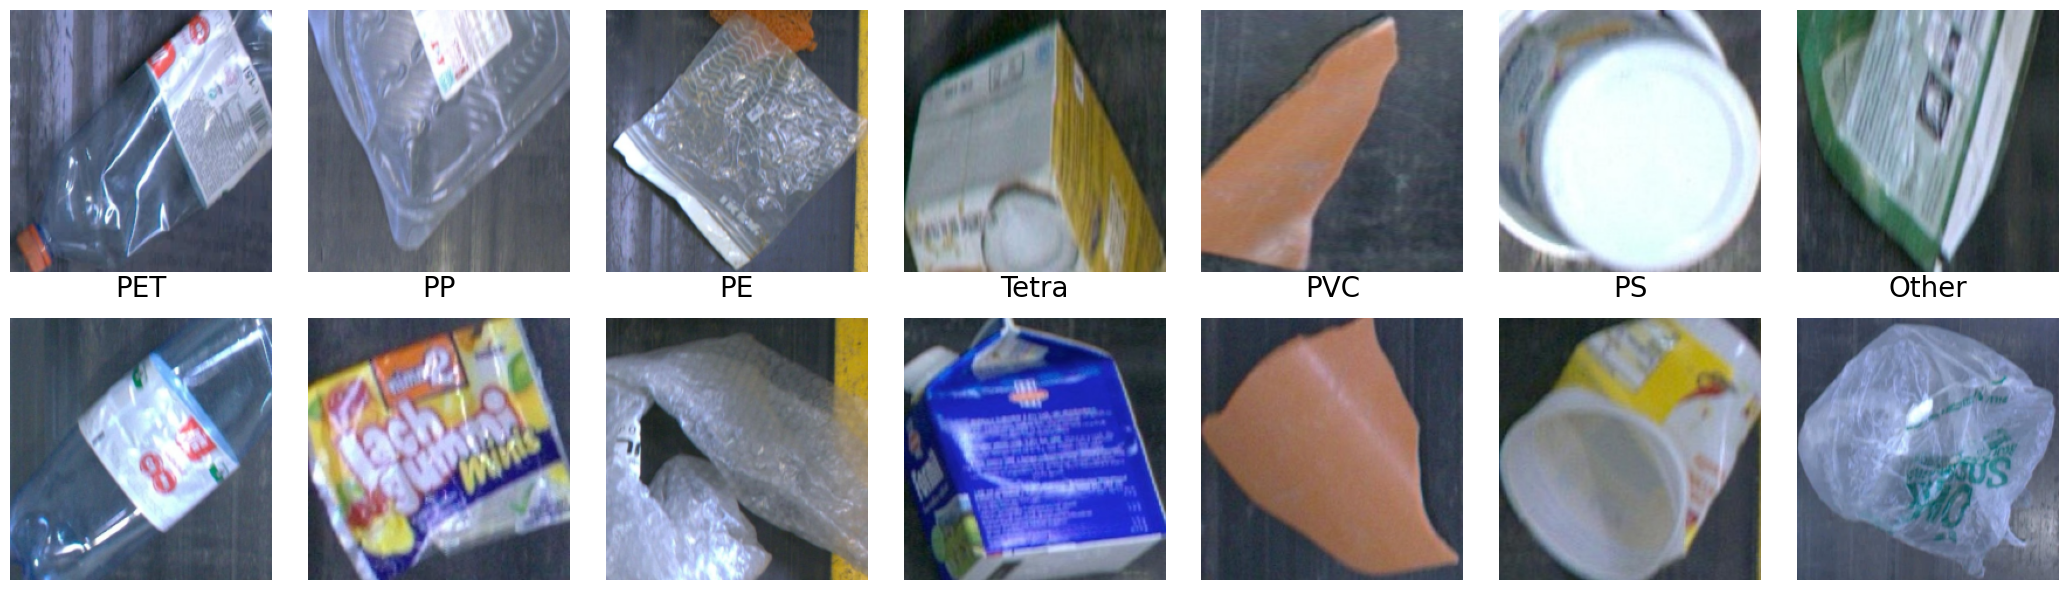

<Figure size 640x480 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
import random
from PIL import Image
from torchvision import transforms
import os

# Define a fixed size for displaying images
display_size = (224, 224)

# Function to display 2 original images per class in a 2-row grid layout
def display_images_per_class(dataset, class_mapping, exclude_classes, num_images=2):
    """Display 2 original images per class, labeled with class names, excluding specific augmented classes."""
    
    # Dictionary to map class labels to image paths (excluding augmented classes and augmented folders)
    class_to_images = {class_name: [] for class_name in class_mapping.keys() if class_name not in exclude_classes}

    # Collect only original images per class
    for img_path, label in zip(dataset.image_paths, dataset.labels):
        # Ensure the path is from 'images_cutout' to include only original images
        if 'images_cutout' in img_path:
            class_name = [k for k, v in class_mapping.items() if v == label and k not in exclude_classes][0]
            class_to_images[class_name].append(img_path)

    # Filter out classes with fewer images than needed
    class_to_images = {k: v for k, v in class_to_images.items() if len(v) >= num_images}

    # Number of columns = number of valid classes
    num_classes = len(class_to_images)
    fig, axes = plt.subplots(2, num_classes, figsize=(num_classes * 3, 6))  # Adjust the figure size as needed

    # Resize transform to ensure consistent image size
    resize_transform = transforms.Resize(display_size)

    for i, (class_name, images) in enumerate(class_to_images.items()):
        sampled_images = random.sample(images, num_images)  # Sample 2 original images per class
        
        for j, img_path in enumerate(sampled_images):
            image = Image.open(img_path)
            image = resize_transform(image)  # Resize to consistent display size
            
            ax = axes[j, i]
            ax.imshow(image)
            ax.axis('off')
            if j == 1:  # Label class name on the second row
                ax.set_title(class_name.split('_')[-1], fontsize=20, pad=15)  # Simplify class name

    plt.tight_layout()
    plt.show()

# Exclude augmented class folders
exclude_classes = {
    'BigBag2_4_Tetra_Augmented', 
    'BigBag2_6_PS_Augmented', 
    'BigBag2_5_PVC_Augmented'
}

# Call the function to display 2 original images per class
display_images_per_class(plastic_dataset, class_mapping, exclude_classes, num_images=2)
plt.savefig('original_images_per_class.jpg', format='jpg', bbox_inches='tight')


### Define Data Augmentations ****withOUT class'Other'
- Augmentation for TETRA (Moderate)
- Augmentation for PS (Light)
- Augmentation for PVC (Light)
- Regular transform for other classes

In [ ]:
# #### Without class 'Other'


# from torchvision import transforms
# from torch.utils.data import Dataset
# from PIL import Image
# import os
# from tqdm import tqdm
# from collections import Counter

# # Updated class mapping to combine classes into unique classes (including 'Augmented')
# # Removed the 'Other' class (class 6)
# class_mapping = {
#     #BigBag2
#     'BigBag2_1_PET': 0,  # PET
#     'BigBag2_2_PP': 1,   # PP
#     'BigBag2_3_PE': 2,   # PE
#     'BigBag2_4_Tetra': 3, # Tetra
#     'BigBag2_5_PVC': 5,  # PVC
#     'BigBag2_6_PS': 4,   # PS
#     'BigBag2_4_Tetra_Augmented': 3,  # Augmented Tetra
#     'BigBag2_6_PS_Augmented': 4,  # Augmented PS
    
#     #BigBag4
#     'BigBag4_1_PET': 0,  # PET
#     'BigBag4_2_PP': 1,   # PP
#     'BigBag4_3_PE': 2,   # PE
#     'BigBag4_4_Tetra': 3, # Tetra
#     'BigBag4_6_PS': 4,   # PS
#     'BigBag4_5_PVC': 5,  # PVC
    
#     #BigBag1
#     'BigBag1_1_PET': 0,  # PET
#     'BigBag1_2_PP': 1,   # PP
#     'BigBag1_3_PE': 2,   # PE
#     'BigBag1_4_Tetra': 3, # Tetra
#     'BigBag1_6_PS': 4,   # PS
    
#     #BigBag3
#     'BigBag3_PET': 0,  # PET
#     'BigBag3_2_PP': 1,   # PP
#     'BigBag3_PE': 2,   # PE
#     'BigBag3_TETRA': 3, # Tetra
#     #'BigBag3_PVC': 5, # PVC
#     'BigBag3_6_PS': 4,   # PS
    
#     'DWRL7_extension_2_PVC': 5,  # PVC
#     'BigBag2_5_PVC_Augmented': 5,  # Augmented PVC
# }

# class CustomPlasticDataset(Dataset):
#     def __init__(self, root_dir, class_mapping, transform, tetra_transform=None, ps_transform=None, pvc_transform=None, diverse_transform=None):
#         self.root_dir = root_dir
#         self.class_mapping = class_mapping
#         self.transform = transform
#         self.tetra_transform = tetra_transform
#         self.ps_transform = ps_transform
#         self.pvc_transform = pvc_transform
#         self.diverse_transform = diverse_transform
#         self.image_paths = []
#         self.labels = []
        
#         # Gather image paths and labels
#         for class_folder in class_mapping.keys():
#             # Load original images
#             image_dir = os.path.join(root_dir, class_folder, 'images_cutout')
#             if os.path.exists(image_dir):
#                 image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
#                 print(f"Loaded {len(image_files)} original images for {class_folder}")
#                 self.image_paths.extend([os.path.join(image_dir, img) for img in image_files])
#                 self.labels.extend([class_mapping[class_folder]] * len(image_files))

#             # Load augmented images if they exist
#             augmented_dir = os.path.join(root_dir, class_folder)  # Path to the augmented class
#             if os.path.exists(augmented_dir) and 'Augmented' in class_folder:
#                 augmented_files = [f for f in os.listdir(augmented_dir) if f.endswith(('.jpg', '.png'))]
#                 print(f"Loaded {len(augmented_files)} augmented images for {class_folder}")
#                 self.image_paths.extend([os.path.join(augmented_dir, img) for img in augmented_files])
#                 self.labels.extend([class_mapping[class_folder]] * len(augmented_files))  # Map to the same class label

#     def __len__(self):
#         return len(self.image_paths)
    
#     def __getitem__(self, idx):
#         img_path = self.image_paths[idx]
#         image = Image.open(img_path)
#         label = self.labels[idx]
        
#         # Apply specific transformations based on class
#         if label == 3:  # Tetra
#             image = self.tetra_transform(image)
#         elif label == 4:  # PS
#             image = self.ps_transform(image)
#         elif label == 5:  # PVC
#             image = self.pvc_transform(image)
#         else:
#             # Use diverse_transform with a 50% chance for other classes
#             if self.diverse_transform is not None and random.random() > 0.5:
#                 image = self.diverse_transform(image)
#             else:
#                 image = self.transform(image)
        
#         return image, label


# # Augmentation for TETRA (Moderate)
# tetra_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(30),
#     transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
#     transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Augmentation for PS (Light)
# ps_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomCrop(224, padding=4),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Regular transform for other classes
# regular_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
# ])
    
# # Augmentation for PVC (Light)
# pvc_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.ColorJitter(brightness=0.3, contrast=0.3),
#     transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Define more diverse transformations for augmentation
# diverse_transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip with 50% probability
#     transforms.RandomRotation(degrees=30),  # Random rotation by up to 30 degrees
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color adjustments
#     transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  # Random crop with resizing
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# def augment_and_save_images(original_dataset, class_label, transform, target_dir, num_augmented_images):
#     os.makedirs(target_dir, exist_ok=True)  # Create the target directory if it doesn't exist
#     class_images = [original_dataset.image_paths[idx] for idx, label in enumerate(original_dataset.labels) if label == class_label]

#     for img_path in tqdm(class_images, desc=f'Augmenting Class {class_label}'):
#         img = Image.open(img_path)
#         for i in range(num_augmented_images):
#             augmented_img = transform(img)  # Apply the transformation
#             augmented_img = transforms.ToPILImage()(augmented_img)  # Convert back to PIL Image
            
#             # Create a unique filename using the original filename and the index
#             base_filename = os.path.basename(img_path).split('.')[0]  # Get the original filename without extension
#             augmented_img.save(os.path.join(target_dir, f'augmented_{base_filename}_{i}.png'))  # Save with a unique name

# # Function to count images in each class
# def count_images_in_classes(base_dir, class_mapping):
#     class_counts = {class_name: 0 for class_name in class_mapping.keys()}

#     for class_name in class_mapping.keys():
#         # Check for original images
#         image_dir = os.path.join(base_dir, class_name, 'images_cutout')  # Original images path
#         if os.path.exists(image_dir):
#             image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
#             class_counts[class_name] += len(image_files)

#         # Check for augmented images in their respective folders
#         if 'Augmented' in class_name:
#             augmented_dir = os.path.join(base_dir, class_name)  # Path to the augmented class
#             if os.path.exists(augmented_dir):
#                 augmented_files = [f for f in os.listdir(augmented_dir) if f.endswith(('.jpg', '.png'))]
#                 class_counts[class_name] += len(augmented_files)  # Count augmented images

#     return class_counts

# # Directory where all class folders are stored
# data_dir = '/raid/home/somayeh.shami/project/somayeh_workspace/DWRL7/data'

# # Create dataset instance
# plastic_dataset = CustomPlasticDataset(
#     root_dir=data_dir, 
#     class_mapping=class_mapping, 
#     transform=regular_transform,
#     tetra_transform=tetra_transform,
#     ps_transform=ps_transform,
#     pvc_transform=pvc_transform,
#     diverse_transform=diverse_transform 
# )

# # After creating the dataset instance, count the classes
# initial_class_counts = Counter(plastic_dataset.labels)
# print('Initial ClassCounts after augmentation:', initial_class_counts)

Loaded 742 original images for BigBag2_1_PET
Loaded 1403 original images for BigBag2_2_PP
Loaded 1203 original images for BigBag2_3_PE
Loaded 192 original images for BigBag2_4_Tetra
Loaded 4 original images for BigBag2_5_PVC
Loaded 227 original images for BigBag2_6_PS
Loaded 1350 augmented images for BigBag2_4_Tetra_Augmented
Loaded 1694 augmented images for BigBag2_6_PS_Augmented
Loaded 904 original images for BigBag4_1_PET
Loaded 1483 original images for BigBag4_2_PP
Loaded 833 original images for BigBag4_3_PE
Loaded 173 original images for BigBag4_4_Tetra
Loaded 254 original images for BigBag4_6_PS
Loaded 3 original images for BigBag4_5_PVC
Loaded 458 original images for BigBag1_1_PET
Loaded 414 original images for BigBag1_2_PP
Loaded 518 original images for BigBag1_3_PE
Loaded 21 original images for BigBag1_4_Tetra
Loaded 47 original images for BigBag1_6_PS
Loaded 391 original images for BigBag3_PET
Loaded 345 original images for BigBag3_PE
Loaded 70 original images for BigBag3_TET

### Delete unwanted folders

In [99]:
# import shutil
# import os

# # Paths to the augmented folders
# tetra_augmented_dir = os.path.join(data_dir, 'BigBag2_4_Tetra_Augmented')
# ps_augmented_dir = os.path.join(data_dir, 'BigBag2_6_PS_Augmented')
# pvc_augmented_dir = os.path.join(data_dir, 'BigBag2_5_PVC_Augmented')

# # Function to delete folders
# def delete_folder(folder_path):
#     if os.path.exists(folder_path):
#         shutil.rmtree(folder_path)  # Deletes the folder and all its contents
#         print(f"Deleted folder: {folder_path}")
#     else:
#         print(f"Folder does not exist: {folder_path}")

# # Delete the augmented folders
# delete_folder(tetra_augmented_dir)
# delete_folder(ps_augmented_dir)
# delete_folder(pvc_augmented_dir)

Deleted folder: /raid/home/somayeh.shami/project/somayeh_workspace/DWRL7/data/BigBag2_4_Tetra_Augmented
Deleted folder: /raid/home/somayeh.shami/project/somayeh_workspace/DWRL7/data/BigBag2_6_PS_Augmented
Deleted folder: /raid/home/somayeh.shami/project/somayeh_workspace/DWRL7/data/BigBag2_5_PVC_Augmented


###  Augmentation for Tetra, PS and PVC

In [4]:
from torchvision import transforms

# # Define more diverse transformations for augmentation
# diverse_transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip with 50% probability
#     transforms.RandomRotation(degrees=30),  # Random rotation by up to 30 degrees
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color adjustments
#     transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  # Random crop with resizing
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# Augment images for Tetra, PS, and PVC

# # Augment for Tetra (class 3) with fewer images (~2 augmentations per original)
# augment_and_save_images(
#     plastic_dataset, class_label=3,
#     transform=diverse_transform,
#     target_dir=os.path.join(data_dir, 'BigBag2_4_Tetra_Augmented'),
#     num_augmented_images=3
# )

# # Augment for PS (class 4) with fewer images (~2 augmentations per original)
# augment_and_save_images(
#     plastic_dataset, class_label=4,
#     transform=diverse_transform,
#     target_dir=os.path.join(data_dir, 'BigBag2_6_PS_Augmented'),
#     num_augmented_images=2
# )

# # Augment for PVC (class 5) with fewer images (~5 augmentations per original)
# augment_and_save_images(
#     plastic_dataset, class_label=5,
#     transform=diverse_transform,
#     target_dir=os.path.join(data_dir, 'BigBag2_5_PVC_Augmented'),
#     num_augmented_images=3
# )

# # Count classes again after augmentation (if reloading dataset)
# augmented_class_counts = count_images_in_classes(data_dir, class_mapping)
# print('ClassCounts after augmentation:', augmented_class_counts)

Augmenting Class 5: 100%|██████████| 654/654 [02:02<00:00,  5.32it/s]

ClassCounts after augmentation: {'BigBag2_1_PET': 742, 'BigBag2_2_PP': 1403, 'BigBag2_3_PE': 1203, 'BigBag2_4_Tetra': 192, 'BigBag2_5_PVC': 4, 'BigBag2_6_PS': 227, 'BigBag2_7_Other': 1268, 'BigBag2_4_Tetra_Augmented': 1350, 'BigBag2_6_PS_Augmented': 1694, 'BigBag4_1_PET': 904, 'BigBag4_2_PP': 1483, 'BigBag4_3_PE': 833, 'BigBag4_4_Tetra': 173, 'BigBag4_6_PS': 254, 'BigBag4_5_PVC': 3, 'BigBag4_7_Other': 1373, 'BigBag1_1_PET': 458, 'BigBag1_2_PP': 414, 'BigBag1_3_PE': 518, 'BigBag1_4_Tetra': 21, 'BigBag1_6_PS': 47, 'BigBag1_7_Other': 984, 'BigBag3_PET': 391, 'BigBag3_PE': 345, 'BigBag3_TETRA': 70, 'BigBag3_PS': 319, 'BigBag3_Other': 702, 'DWRL7_extension_2_PVC': 647, 'BigBag2_5_PVC_Augmented': 1962}


In [14]:
# After creating the dataset instance, count the classes
initial_class_counts = Counter(plastic_dataset.labels)
print('Initial ClassCounts after augmentation:', initial_class_counts)

Initial ClassCounts after augmentation: Counter({6: 4327, 1: 3899, 2: 2899, 5: 2616, 0: 2495, 4: 2400, 3: 1806})


### Class Mapping and Custom Dataset Definition
- Class mapping for dataset organization
- Custom dataset class to handle image loading and transformations

### Data Preparation and Visualization
- Dataset Setup: Directory setup, dataset instance creation, class frequency counting.
- Weight Calculation: Class weights based on frequency for the WeightedRandomSampler.
- Train/Validation Split: Splitting the dataset into training and validation sets.
- DataLoaders: Creating DataLoaders for both training and validation.
- Visualization Function: Function to display images with their corresponding labels.
- Image Display: Showing a few images from both training and validation sets.

Loaded 742 original images for BigBag2_1_PET
Loaded 1403 original images for BigBag2_2_PP
Loaded 1203 original images for BigBag2_3_PE
Loaded 192 original images for BigBag2_4_Tetra
Loaded 4 original images for BigBag2_5_PVC
Loaded 227 original images for BigBag2_6_PS
Loaded 1350 augmented images for BigBag2_4_Tetra_Augmented
Loaded 1694 augmented images for BigBag2_6_PS_Augmented
Loaded 904 original images for BigBag4_1_PET
Loaded 1483 original images for BigBag4_2_PP
Loaded 833 original images for BigBag4_3_PE
Loaded 173 original images for BigBag4_4_Tetra
Loaded 254 original images for BigBag4_6_PS
Loaded 3 original images for BigBag4_5_PVC
Loaded 458 original images for BigBag1_1_PET
Loaded 414 original images for BigBag1_2_PP
Loaded 518 original images for BigBag1_3_PE
Loaded 21 original images for BigBag1_4_Tetra
Loaded 47 original images for BigBag1_6_PS
Loaded 391 original images for BigBag3_PET
Loaded 345 original images for BigBag3_PE
Loaded 70 original images for BigBag3_TET

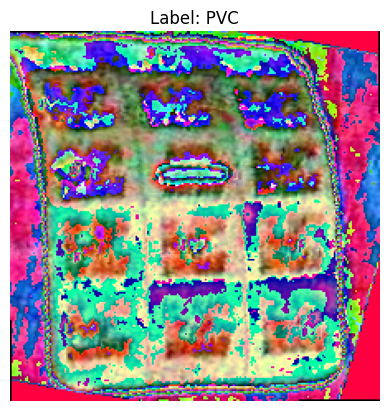

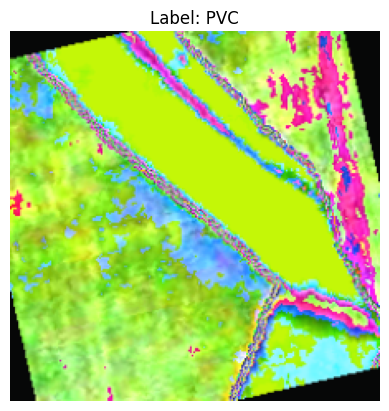

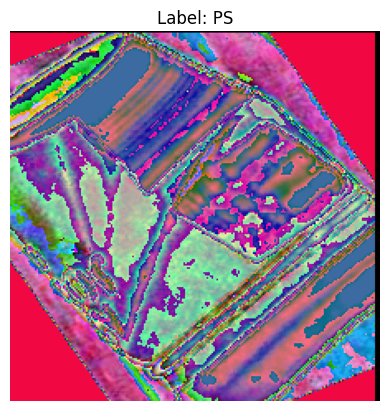

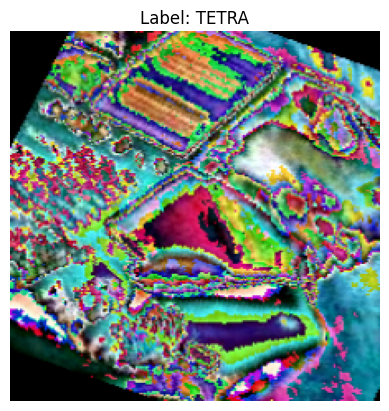

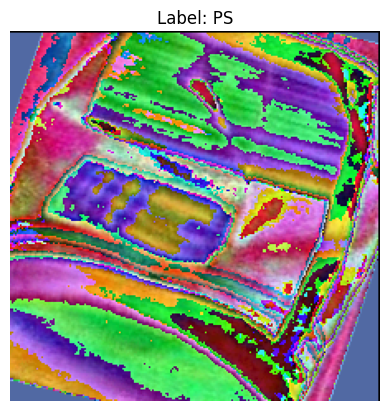

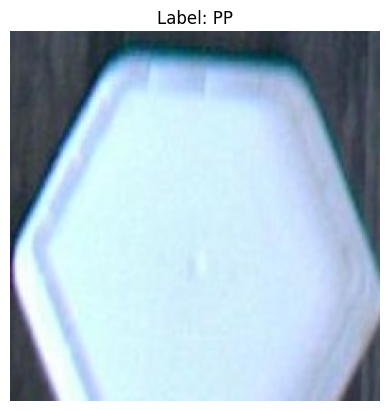

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import random

# # Define how many images to show
# num_images_to_show = 6  # Adjust this as needed

# # Function to show individual images with their labels
# def show_image(image, label, class_names):
#     image = image.cpu().numpy()  # Move tensor to CPU and convert to numpy
#     image = np.transpose(image, (1, 2, 0))  # Transpose to (H, W, C)
    
#     # Unnormalize the image
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     image = std * image + mean  # Revert normalization
#     image = np.clip(image, 0, 1)  # Clip values to [0, 1]

#     plt.imshow(image)
#     plt.title(f"Label: {class_names[label]}")
#     plt.axis("off")
#     plt.show()

# # Updated class names for visualization (consistent with class mapping)
# class_names = [
#     'PET',      # Combined from BigBag2 and BigBag4
#     'PP',       # Combined from BigBag2 and BigBag4
#     'PE',       # Combined from BigBag2 and BigBag4
#     'TETRA',    # Combined from BigBag2 and BigBag4
#     'PS',        # Combined from BigBag2 and BigBag4
#     'PVC',      # Add combined class name
#     'Other'
# ]

# # Directory where all class folders are stored
# data_dir = '/raid/home/somayeh.shami/project/somayeh_workspace/DWRL7/data'

# # Create dataset instance
# plastic_dataset = CustomPlasticDataset(
#     root_dir=data_dir, 
#     class_mapping=class_mapping, 
#     transform=regular_transform,
#     tetra_transform=tetra_transform,
#     ps_transform=ps_transform,
#     pvc_transform=pvc_transform
# )

# # Show a few random images with their labels
# for _ in range(num_images_to_show):
#     idx = random.randint(0, len(plastic_dataset) - 1)  # Get a random index
#     image, label = plastic_dataset[idx]  # Get the image and label
#     show_image(image, label, class_names)  # Display the image

In [12]:
from torch.utils.data import Subset, random_split
from collections import defaultdict, Counter
import random

# Step 1: Separate Original and Augmented Images by class
original_indices_by_class = defaultdict(list)
augmented_indices_by_class = defaultdict(list)

for i, (path, label) in enumerate(zip(plastic_dataset.image_paths, plastic_dataset.labels)):
    if 'Augmented' not in path:  # Original images
        original_indices_by_class[label].append(i)
    else:  # Augmented images
        augmented_indices_by_class[label].append(i)

# Step 2: Calculate test size based on total images (original + augmented)
test_indices = []
train_val_indices_by_class = defaultdict(list)

for label, original_indices in original_indices_by_class.items():
    total_images_in_class = len(original_indices) + len(augmented_indices_by_class[label])  # Total images in class
    test_size = int(0.1 * total_images_in_class)  # 10% of total images (original + augmented)
    
    # Ensure there are enough original images to select from for the test set
    if test_size > len(original_indices):
        raise ValueError(f"Not enough original images in class {label} for test set.")
    
    random.shuffle(original_indices)  # Shuffle for randomness
    test_indices.extend(original_indices[:test_size])  # First 10% goes to test set
    train_val_indices_by_class[label].extend(original_indices[test_size:])  # Remaining original images

# Step 3: Combine remaining original and augmented images for training/validation split
train_val_indices = []
for label, original_remaining in train_val_indices_by_class.items():
    train_val_indices.extend(original_remaining)  # Add remaining original images
    train_val_indices.extend(augmented_indices_by_class[label])  # Add augmented images for this class

# Step 4: Split the remaining images into training and validation sets (80/20 split)
train_size = int(0.8 * len(train_val_indices))  # 80% for training
val_size = len(train_val_indices) - train_size  # 20% for validation

# Randomly split the combined dataset into train and validation sets
train_indices, val_indices = random_split(train_val_indices, [train_size, val_size])

# Step 5: Create Subsets for train, validation, and test sets
train_dataset = Subset(plastic_dataset, train_indices)
val_dataset = Subset(plastic_dataset, val_indices)
test_dataset = Subset(plastic_dataset, test_indices)  # Test set with only original images

# Step 6: Print and check sizes
print(f'Training set size (with original + augmented): {len(train_dataset)}')
print(f'Validation set size (with original + augmented): {len(val_dataset)}')
print(f'Test set size (with original only): {len(test_dataset)}')

# Optional: Count the number of images per class in the test set
test_class_counts = Counter(plastic_dataset.labels[i] for i in test_indices)
print("Test set class distribution:", test_class_counts)

Training set size (with original + augmented): 14721
Validation set size (with original + augmented): 3681
Test set size (with original only): 2040
Test set class distribution: Counter({6: 432, 1: 389, 2: 289, 5: 261, 0: 249, 4: 240, 3: 180})


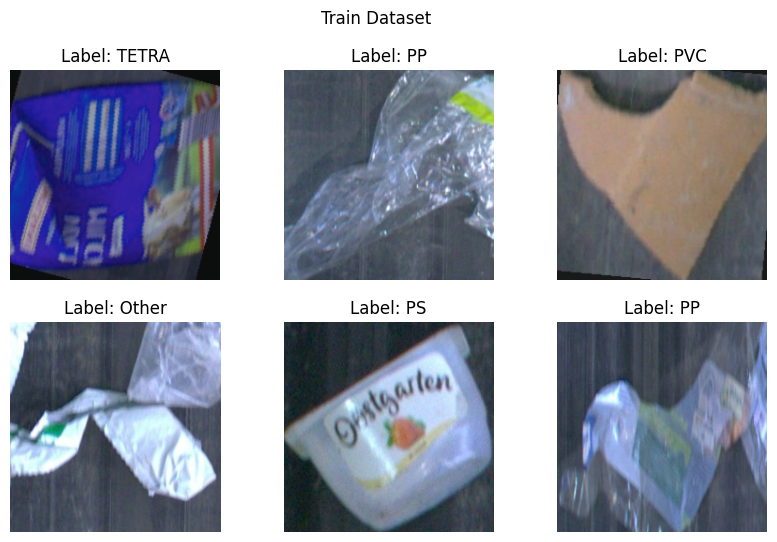

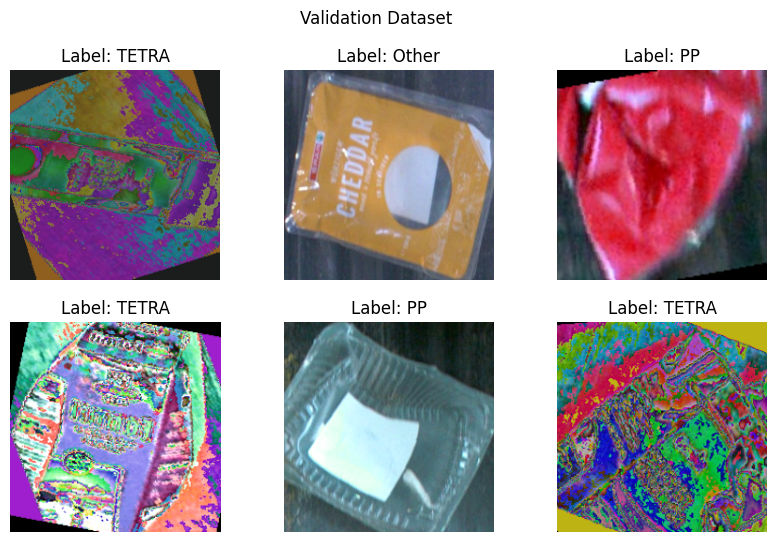

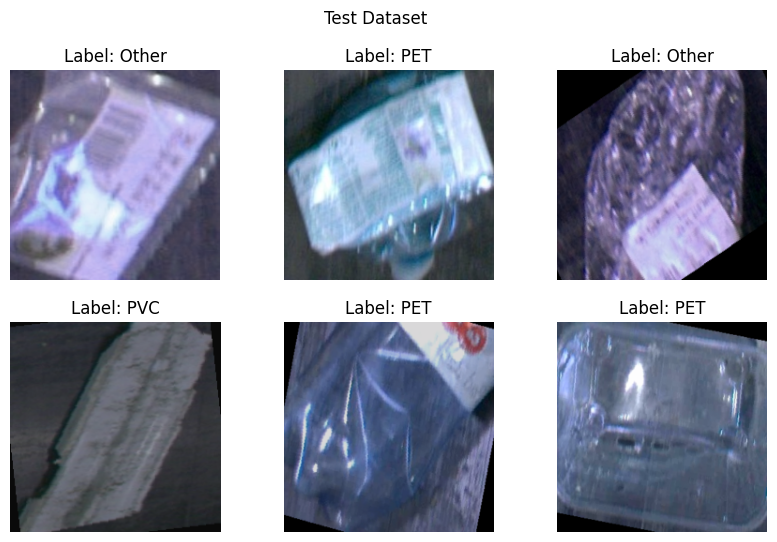

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Function to show multiple images with labels
def show_images_from_dataset(dataset, num_images_to_show, class_names, title):
    plt.figure(figsize=(10, 6))
    
    for i in range(num_images_to_show):
        idx = random.randint(0, len(dataset) - 1)  # Get a random index
        image, label = dataset[idx]  # Get the image and label

        image = image.cpu().numpy()  # Move tensor to CPU and convert to numpy
        image = np.transpose(image, (1, 2, 0))  # Transpose to (H, W, C)

        # Unnormalize the image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean  # Revert normalization
        image = np.clip(image, 0, 1)  # Clip values to [0, 1]

        plt.subplot(2, 3, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {class_names[label]}")
        plt.axis("off")
    
    plt.suptitle(title)
    plt.show()

# Class names for the dataset
class_names = ['PET', 'PP', 'PE', 'TETRA', 'PS', 'PVC', 'Other']

# Number of images to show
num_images_to_show = 6

# Show 6 random images from the training, validation, and test datasets
show_images_from_dataset(train_dataset, num_images_to_show, class_names, "Train Dataset")
show_images_from_dataset(val_dataset, num_images_to_show, class_names, "Validation Dataset")
show_images_from_dataset(test_dataset, num_images_to_show, class_names, "Test Dataset")

In [24]:
# # Count the frequency of each class in the dataset
# class_counts = Counter(plastic_dataset.labels)
# print('ClassCounts:', class_counts)

# # Calculate weights for each class: inverse of frequency
# class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}

# # Define train/validation/test split ratio
# train_size = int(0.8 * len(plastic_dataset))  # 80% for training
# val_size = int(0.1 * len(plastic_dataset))    # 10% for validation
# test_size = len(plastic_dataset) - train_size - val_size  # Remaining 10% for testing

# # Split the dataset into training, validation, and test sets
# train_dataset, val_dataset, test_dataset = random_split(plastic_dataset, [train_size, val_size, test_size])

# # Calculate sample weights for the training dataset
# train_labels = [plastic_dataset.labels[i] for i in train_dataset.indices]  # Get labels from the original dataset
# train_class_counts = Counter(train_labels)
# train_class_weights = {cls: 1.0 / count for cls, count in train_class_counts.items()}

# # Assign weight to each sample in the training dataset
# sample_weights = [train_class_weights[label] for label in train_labels]

# # Create a WeightedRandomSampler for the training dataset
# sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# # Create DataLoaders
# batch_size = 32
# train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)  # Weighted sampling for training
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # No sampling for validation
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # No sampling for testing

# # Print to confirm sizes
# print(f'Training set size: {len(train_dataset)}')
# print(f'Validation set size: {len(val_dataset)}')
# print(f'Test set size: {len(test_dataset)}')

In [6]:
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter

# Count the frequency of each class in the entire dataset (for reference)
class_counts = Counter(plastic_dataset.labels)
print('ClassCounts (entire dataset):', class_counts)

# Count the frequency of each class in the training dataset
train_labels = [plastic_dataset.labels[i] for i in train_dataset.indices]
train_class_counts = Counter(train_labels)

# Check for zero counts and prevent division by zero
if any(count == 0 for count in train_class_counts.values()):
    print("Warning: One or more classes have zero counts in the training dataset!")

# Step 1: Calculate weights for the training dataset
train_class_weights = {cls: 1.0 / count if count > 0 else 0.0 for cls, count in train_class_counts.items()}
print("Training Class Weights:", train_class_weights)

# Step 2: Create sample weights based on the training labels
sample_weights = [train_class_weights[label] for label in train_labels]
print("Sample Weights (sample of first 10):", sample_weights[:10])  # Show a small sample for debugging

# Step 3: Create a WeightedRandomSampler for the training dataset
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Step 4: Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)  # Weighted sampling for training
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)  # No sampling for validation
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)  # No sampling for testing

# Step 5: Print to confirm sizes and weights
print(f'Training set size (with original + augmented): {len(train_dataset)}')
print(f'Validation set size (with original + augmented): {len(val_dataset)}')
print(f'Test set size (original only): {len(test_dataset)}')
print("Training class weights:", train_class_weights)

ClassCounts (entire dataset): Counter({6: 4327, 1: 3899, 2: 2899, 5: 2616, 0: 2495, 4: 2400, 3: 1806})
Training Class Weights: {5: 0.0005241090146750524, 6: 0.00032268473701193933, 1: 0.00035855145213338117, 3: 0.0007674597083653108, 2: 0.0004830917874396135, 0: 0.0005494505494505495, 4: 0.0005773672055427252}
Sample Weights (sample of first 10): [0.0005241090146750524, 0.00032268473701193933, 0.00035855145213338117, 0.0005241090146750524, 0.0005241090146750524, 0.0007674597083653108, 0.00032268473701193933, 0.00032268473701193933, 0.0007674597083653108, 0.00032268473701193933]
Training set size (with original + augmented): 14721
Validation set size (with original + augmented): 3681
Test set size (original only): 2040
Training class weights: {5: 0.0005241090146750524, 6: 0.00032268473701193933, 1: 0.00035855145213338117, 3: 0.0007674597083653108, 2: 0.0004830917874396135, 0: 0.0005494505494505495, 4: 0.0005773672055427252}


In [67]:
####  reducing "Other" class (class 6) impact in the training process


# from torch.utils.data import DataLoader, WeightedRandomSampler
# from collections import Counter

# # Count the frequency of each class in the entire dataset (for reference)
# class_counts = Counter(plastic_dataset.labels)
# print('ClassCounts (entire dataset):', class_counts)

# # Count the frequency of each class in the training dataset
# train_labels = [plastic_dataset.labels[i] for i in train_dataset.indices]
# train_class_counts = Counter(train_labels)

# # Check for zero counts and prevent division by zero
# if any(count == 0 for count in train_class_counts.values()):
#     print("Warning: One or more classes have zero counts in the training dataset!")

# # Step 1: Calculate weights for the training dataset
# train_class_weights = {cls: 1.0 / count if count > 0 else 0.0 for cls, count in train_class_counts.items()}

# # Adjust the weight for the "Other" class (class 6) to make it lower
# other_class_weight_reduction_factor = 0.5  # Adjust as needed (e.g., reduce by 90%)
# train_class_weights[6] *= other_class_weight_reduction_factor

# # Print the adjusted training class weights
# print("Adjusted Training Class Weights (including reduced 'Other' class weight):", train_class_weights)

# # Step 2: Create sample weights based on the training labels
# sample_weights = [train_class_weights[label] for label in train_labels]
# print("Sample Weights (sample of first 10):", sample_weights[:10])  # Show a small sample for debugging

# # Step 3: Create a WeightedRandomSampler for the training dataset
# sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# # Step 4: Create DataLoaders
# batch_size = 32

# train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)  # Weighted sampling for training
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)  # No sampling for validation
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)  # No sampling for testing

# # Step 5: Print to confirm sizes and weights
# print(f'Training set size (with original + augmented): {len(train_dataset)}')
# print(f'Validation set size (with original + augmented): {len(val_dataset)}')
# print(f'Test set size (original only): {len(test_dataset)}')
# print("Adjusted Training class weights:", train_class_weights)

# # To revert, simply comment out or remove the line modifying `train_class_weights[6]` and set `other_class_weight_reduction_factor = 1.0`.


ClassCounts (entire dataset): Counter({6: 4327, 1: 3300, 2: 2899, 5: 2616, 4: 2541, 0: 2495, 3: 1806})
Adjusted Training Class Weights (including reduced 'Other' class weight): {6: 0.00015943877551020407, 0: 0.0005509641873278236, 5: 0.0005302226935312832, 3: 0.00078003120124805, 2: 0.0004798464491362764, 1: 0.00042444821731748726, 4: 0.0005458515283842794}
Sample Weights (sample of first 10): [0.00015943877551020407, 0.0005509641873278236, 0.0005302226935312832, 0.00078003120124805, 0.0004798464491362764, 0.0004798464491362764, 0.00042444821731748726, 0.00015943877551020407, 0.0005302226935312832, 0.0005302226935312832]
Training set size (with original + augmented): 14391
Validation set size (with original + augmented): 3598
Test set size (original only): 1995
Adjusted Training class weights: {6: 0.00015943877551020407, 0: 0.0005509641873278236, 5: 0.0005302226935312832, 3: 0.00078003120124805, 2: 0.0004798464491362764, 1: 0.00042444821731748726, 4: 0.0005458515283842794}


In [26]:
#print("Sample weights:", sample_weights[:10])  # Print first 10 sample weights for verification

In [27]:
# # Assuming your original dataset is named `plastic_dataset`
# original_labels = [plastic_dataset.labels[i] for i in train_dataset.indices]
# class_counts = Counter(original_labels)
# print('ClassCounts after sampling:', class_counts)

In [28]:
# # Create a WeightedRandomSampler for the entire dataset
# sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# # Create DataLoader with the sampler
# train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
# print('Number of batches in train_loader:', len(train_loader))

In [18]:
print(f'Training loader length: {len(train_loader)}')
print(f'Validation loader length: {len(val_loader)}')
print(f"Number of batches in train_loader: {len(train_loader)}")

Training loader length: 461
Validation loader length: 116
Number of batches in train_loader: 461


In [19]:
for idx, (inputs, labels) in enumerate(train_loader):
    print(f'Batch index: {idx}, Inputs shape: {inputs.shape}, Labels shape: {labels.shape}')
    if idx == 0:  # Just show the first batch
        break

Batch index: 0, Inputs shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32])


In [ ]:
# # Get a batch of images and labels from the training set
# train_images, train_labels = None, None  # Initialize variables

# try:
#     train_data_iter = iter(train_loader)
#     train_images, train_labels = next(train_data_iter)
#     print("Displaying training images...")
#     print(f"Train Images Shape: {train_images.shape}, Train Labels Shape: {train_labels.shape}")
# except IndexError as e:
#     print(f"Error while fetching training data: {e}")

# # Show training images only if they were successfully fetched
# if train_images is not None and train_labels is not None:
#     for i in range(min(num_images_to_show, len(train_images))):  # Adjusted here
#         show_image(train_images[i], train_labels[i].item(), class_names)

# # Get a batch of images and labels from the validation set
# val_images, val_labels = None, None  # Initialize variables

# try:
#     val_data_iter = iter(val_loader)
#     val_images, val_labels = next(val_data_iter)
#     print("Displaying validation images...")
# except IndexError as e:
#     print(f"Error while fetching validation data: {e}")

# # Show validation images only if they were successfully fetched
# if val_images is not None and val_labels is not None:
#     for i in range(min(num_images_to_show, len(val_images))):  # Adjusted here
#         show_image(val_images[i], val_labels[i].item(), class_names)

Displaying training images...
Training Images Shape: torch.Size([32, 3, 224, 224]), Training Labels Shape: torch.Size([32])


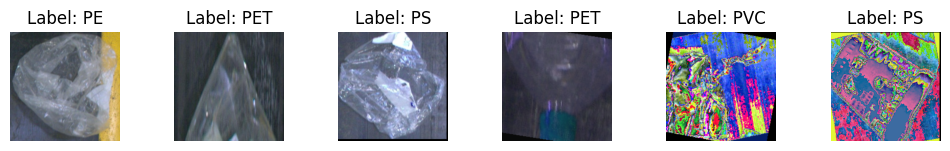

Displaying validation images...
Validation Images Shape: torch.Size([32, 3, 224, 224]), Validation Labels Shape: torch.Size([32])


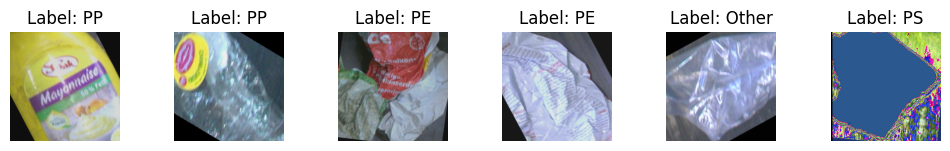

Displaying test images...
Test Images Shape: torch.Size([32, 3, 224, 224]), Test Labels Shape: torch.Size([32])


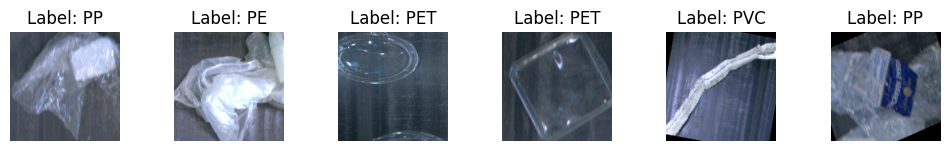

Training Labels: tensor([2, 0, 4, 0, 5, 4, 2, 4, 4, 4, 1, 1, 6, 0, 6, 0, 4, 3, 6, 1, 4, 3, 0, 2,
        3, 4, 1, 1, 2, 2, 2, 3])
Validation Labels: tensor([1, 1, 2, 2, 6, 4, 3, 4, 1, 0, 2, 4, 0, 1, 2, 6, 0, 4, 2, 1, 2, 4, 1, 1,
        4, 4, 2, 6, 2, 3, 6, 6])
Test Labels: tensor([1, 2, 0, 0, 5, 1, 6, 1, 2, 1, 5, 4, 2, 5, 1, 6, 1, 1, 3, 2, 4, 2, 5, 5,
        2, 2, 1, 3, 5, 6, 1, 4])


In [10]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Function to display images in a row with spacing
# def show_images_in_row(images, labels, class_names, image_size=(2, 2), num_images_to_show=6):
#     # Limit the number of images to show
#     num_images = min(num_images_to_show, len(images))

#     # Create a figure with subplots arranged in one row
#     fig, axes = plt.subplots(1, num_images, figsize=(num_images * image_size[0], image_size[1]))
#     fig.subplots_adjust(wspace=0.5)  # Add space between images

#     for i in range(num_images):
#         image = images[i].cpu().numpy()  # Move tensor to CPU and convert to numpy
#         image = np.transpose(image, (1, 2, 0))  # Transpose to (H, W, C)
        
#         # Unnormalize the image
#         mean = np.array([0.485, 0.456, 0.406])
#         std = np.array([0.229, 0.224, 0.225])
#         image = std * image + mean  # Revert normalization
#         image = np.clip(image, 0, 1)  # Clip values to [0, 1]

#         # Display the image in the current subplot
#         axes[i].imshow(image)
#         axes[i].set_title(f"Label: {class_names[labels[i].item()]}")
#         axes[i].axis("off")  # Turn off the axis

#     plt.show()

# # Function to fetch images from a DataLoader and display them in a row
# def fetch_and_display_images_in_row(data_loader, num_images_to_show, class_names, dataset_type='Training', image_size=(2, 2)):
#     images, labels = None, None  # Initialize variables
    
#     try:
#         data_iter = iter(data_loader)
#         images, labels = next(data_iter)
#         print(f"Displaying {dataset_type.lower()} images...")
#         print(f"{dataset_type} Images Shape: {images.shape}, {dataset_type} Labels Shape: {labels.shape}")
#     except IndexError as e:
#         print(f"Error while fetching {dataset_type.lower()} data: {e}")
#         return None, None  # Return None for both if there's an error
    
#     # Show images only if they were successfully fetched
#     if images is not None and labels is not None:
#         show_images_in_row(images, labels, class_names, image_size=image_size, num_images_to_show=num_images_to_show)

#     return labels  # Return the fetched labels

# # Display training images in a row
# train_labels = fetch_and_display_images_in_row(train_loader, num_images_to_show=6, class_names=class_names, dataset_type='Training', image_size=(2, 2))

# # Display validation images in a row
# val_labels = fetch_and_display_images_in_row(val_loader, num_images_to_show=6, class_names=class_names, dataset_type='Validation', image_size=(2, 2))

# # Display test images in a row
# test_labels = fetch_and_display_images_in_row(test_loader, num_images_to_show=6, class_names=class_names, dataset_type='Test', image_size=(2, 2))

# # Print the labels
# print("Training Labels:", train_labels)
# print("Validation Labels:", val_labels)
# print("Test Labels:", test_labels)

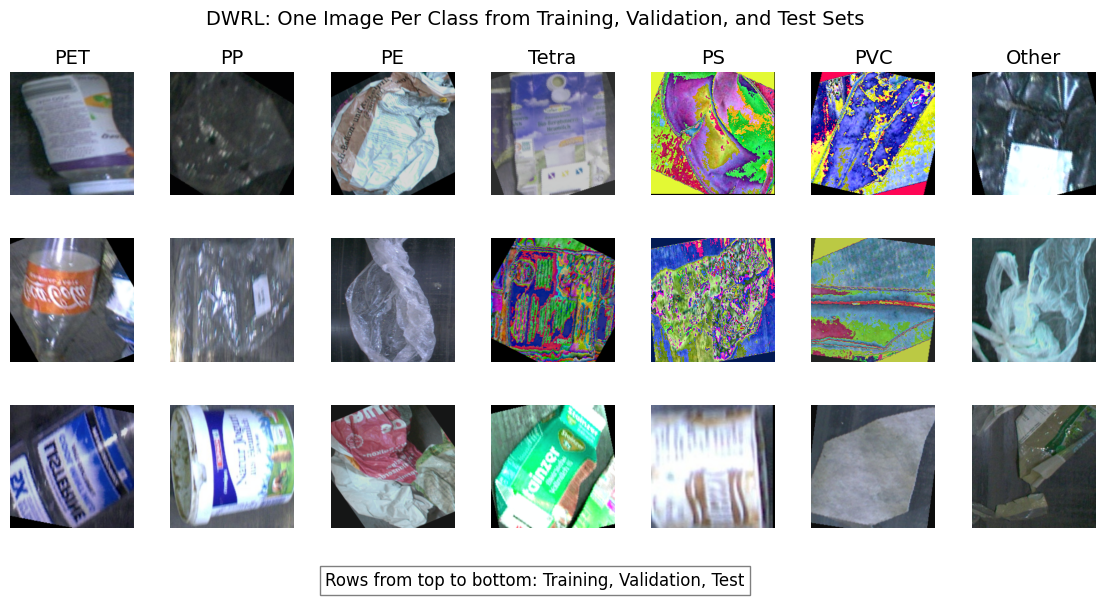

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Function to display images from training, validation, and test datasets
def show_images_from_all_sets(train_loader, val_loader, test_loader, class_names, image_size=(2, 2)):
    # Collect one image per class from each dataset type
    data_types = [('Training', train_loader), ('Validation', val_loader), ('Test', test_loader)]
    fig, axes = plt.subplots(3, len(class_names), figsize=(len(class_names) * image_size[0], 3 * image_size[1]))
    fig.subplots_adjust(wspace=0.3, hspace=0.3)  # Adjust space between images and rows

    for row, (dataset_type, data_loader) in enumerate(data_types):
        images_per_class = {i: None for i in range(len(class_names))}

        # Collect one image per class
        data_iter = iter(data_loader)
        for inputs, labels in data_iter:
            for i in range(len(labels)):
                label = labels[i].item()
                if images_per_class[label] is None:
                    images_per_class[label] = inputs[i]
                if all(v is not None for v in images_per_class.values()):
                    break
            if all(v is not None for v in images_per_class.values()):
                break

        # Display the images in the corresponding row
        for col, (label, image) in enumerate(images_per_class.items()):
            if image is not None:
                image = image.cpu().numpy()  # Move tensor to CPU and convert to numpy
                image = np.transpose(image, (1, 2, 0))  # Transpose to (H, W, C)

                # Unnormalize the image
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                image = std * image + mean  # Revert normalization
                image = np.clip(image, 0, 1)  # Clip values to [0, 1]

                axes[row, col].imshow(image)
                if row == 0:
                    axes[row, col].set_title(f"{class_names[label]}", fontsize=14)
                axes[row, col].axis("off")

    # Add caption below the figure indicating dataset types for each row
    plt.figtext(0.5, 0.02, "Rows from top to bottom: Training, Validation, Test", ha="center", fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.suptitle("DWRL: One Image Per Class from Training, Validation, and Test Sets", fontsize=14)
    plt.savefig('one_image_per_class.png', format='png', bbox_inches='tight')  # Save the figure
    plt.show()

# Class names for the dataset
class_names = ['PET', 'PP', 'PE', 'Tetra', 'PS', 'PVC', 'Other']

# Display one image per class from each dataset
show_images_from_all_sets(train_loader, val_loader, test_loader, class_names, image_size=(2, 2))

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Subset

# Step 1: Function to filter for non-augmented images in a dataset
def filter_non_augmented(dataset, is_augmented_func):
    # Select indices where images are non-augmented
    non_augmented_indices = [i for i, data in enumerate(dataset) if not is_augmented_func(data)]
    return Subset(dataset, non_augmented_indices)

# Step 2: Function to determine if an image is augmented (customize this function based on your dataset structure)
def is_augmented(data):
    # Placeholder logic; modify this function to detect augmented images, e.g., based on filename or metadata
    # Example: return 'augmented' in data[1] if data includes filename or path info
    return False  # Modify with actual logic for identifying augmented images

# Step 3: Create subsets with only non-augmented images
train_non_augmented = filter_non_augmented(train_dataset, is_augmented)
val_non_augmented = filter_non_augmented(val_dataset, is_augmented)
test_non_augmented = filter_non_augmented(test_dataset, is_augmented)

# Step 4: Create data loaders for non-augmented images
batch_size = 32  # Set desired batch size for visualization
train_non_augmented_loader = DataLoader(train_non_augmented, batch_size=batch_size, shuffle=True)
val_non_augmented_loader = DataLoader(val_non_augmented, batch_size=batch_size, shuffle=True)
test_non_augmented_loader = DataLoader(test_non_augmented, batch_size=batch_size, shuffle=True)

# Step 5: Function to display one image per class in each dataset type (Training, Validation, Test)
def show_one_image_per_class(train_loader, val_loader, test_loader, class_names, image_size=(2, 2)):
    # Define data types and loaders for each row (Train, Val, Test)
    data_types = [('Training', train_loader), ('Validation', val_loader), ('Test', test_loader)]
    fig, axes = plt.subplots(3, len(class_names), figsize=(len(class_names) * image_size[0], 3 * image_size[1]))
    fig.subplots_adjust(wspace=0.3, hspace=0.3)  # Adjust space between images and rows

    for row, (dataset_type, data_loader) in enumerate(data_types):
        images_per_class = {i: None for i in range(len(class_names))}

        # Collect one image per class
        for inputs, labels in data_loader:
            for i in range(len(labels)):
                label = labels[i].item()
                if images_per_class[label] is None:  # Only add one image per class
                    images_per_class[label] = inputs[i]
                if all(v is not None for v in images_per_class.values()):  # Break if all classes have an image
                    break
            if all(v is not None for v in images_per_class.values()):
                break

        # Display the images in the corresponding row
        for col, (label, image) in enumerate(images_per_class.items()):
            if image is not None:
                image = image.cpu().numpy()  # Move tensor to CPU and convert to numpy
                image = np.transpose(image, (1, 2, 0))  # Transpose to (H, W, C)

                # Unnormalize the image
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                image = std * image + mean  # Revert normalization
                image = np.clip(image, 0, 1)  # Clip values to [0, 1]

                axes[row, col].imshow(image)
                if row == 0:
                    axes[row, col].set_title(f"{class_names[label]}", fontsize=14)
                axes[row, col].axis("off")

    # Add caption below the figure indicating dataset types for each row
    plt.figtext(0.5, 0.02, "Rows from top to bottom: Training, Validation, Test", ha="center", fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.suptitle("One Image Per Class from Training, Validation, and Test Sets", fontsize=14)
    plt.savefig('one_image_per_class_non_augmented.png', bbox_inches='tight')  # Save the figure
    plt.show()

# Class names for the dataset (update as needed)
class_names = ['PET', 'PP', 'PE', 'TETRA', 'PS', 'PVC', 'OTHER']

# Step 6: Display one image per class from each dataset
show_one_image_per_class(train_non_augmented_loader, val_non_augmented_loader, test_non_augmented_loader, class_names, image_size=(2, 2))


NameError: name 'train_dataset' is not defined

### Class Weight Calculation and Loss Setup
- Class Frequency Counting: Count the number of samples for each class in the dataset.
- Weight Calculation: Calculate weights for each class as the inverse of their frequency.
- Sample Weights: Assign calculated weights to each sample in the dataset.
- WeightedRandomSampler: Create a sampler for the DataLoader that uses these weights.
- PVC Weight Handling: Set a small weight for PVC (class 4), since it is excluded.
- Loss Function Setup: Create a class weight tensor for use in the CrossEntropyLoss.
- Debugging Output: Print the class weights for verification.

In [22]:
import torch
import torch.nn as nn
from collections import Counter

# Count the frequency of each class in the training dataset only (since we will apply the weights in training)
train_labels = [plastic_dataset.labels[i] for i in train_dataset.indices]
train_class_counts = Counter(train_labels)

# Print class counts for debugging
print('Training ClassCounts:', train_class_counts)

# Calculate weights for each class: inverse of frequency for the classes (0 to 6)
class_weights = {cls: 1.0 / count for cls, count in train_class_counts.items() if cls < 7}  # Classes 0-6  #### change 7 to 6 when I removed class 'Other'

# Apply the reduction factor for the "Other" class (class 6)
# if 6 in class_weights:
#     class_weights[6] *= other_class_weight_reduction_factor
    
# Create class_weight_tensor based on the actual class labels (0 to 6)
class_weight_tensor = torch.tensor([1.0] * 7).to(device)  # Default weights if not using sampler (1.0 for all classes)    #### change 7 to 6 when I removed class 'Other'
class_weight_tensor = torch.tensor([class_weights.get(i, 0.0) for i in range(7)]).to(device)  # Weights for classes 0-6   #### change 7 to 6 when I removed class 'Other'

# Use CrossEntropyLoss with class weights
criterion = nn.CrossEntropyLoss(weight=class_weight_tensor)

# Print class weights for debugging
print("Class weights for loss function:", class_weight_tensor)
print("Class weight tensor shape:", class_weight_tensor.shape)  # Should be [6]

Training ClassCounts: Counter({6: 3059, 1: 2821, 2: 2108, 5: 1864, 0: 1818, 4: 1745, 3: 1306})
Class weights for loss function: tensor([0.0006, 0.0004, 0.0005, 0.0008, 0.0006, 0.0005, 0.0003],
       device='cuda:0')
Class weight tensor shape: torch.Size([7])


In [23]:
# Calculate the total sum of class weights
total_weight = sum(class_weight_tensor.cpu().numpy())

# Normalize the weights
normalized_class_weight_tensor = class_weight_tensor / total_weight

# Convert back to tensor if necessary
normalized_class_weight_tensor = normalized_class_weight_tensor.to(device)

# Print the normalized weights for debugging
print("Normalized Class Weights:", normalized_class_weight_tensor)

# Use CrossEntropyLoss with class weights
criterion = nn.CrossEntropyLoss(weight=normalized_class_weight_tensor)

Normalized Class Weights: tensor([0.1536, 0.0990, 0.1325, 0.2138, 0.1600, 0.1498, 0.0913],
       device='cuda:0')


In [24]:
def prepare_model(num_classes=7):   #### change 7 to 6 when I removed class 'Other'
    """Load a pre-trained Resnet18 model and modify it for DWRL."""
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

In [25]:
for cls, count in class_counts.items():
    print(f"Class {cls}: {count} samples")

Class 0: 2495 samples
Class 1: 3899 samples
Class 2: 2899 samples
Class 3: 1806 samples
Class 5: 2616 samples
Class 4: 2400 samples
Class 6: 4327 samples


In [45]:
# import torch
# from tqdm import tqdm
# from torch.utils.data import WeightedRandomSampler, DataLoader
# from collections import Counter

# # Count the frequency of each class in the dataset
# class_counts = Counter(plastic_dataset.labels)

# # Calculate weights for each class: inverse of frequency for the combined classes (0 to 4)
# class_weights = {cls: 1.0 / count for cls, count in class_counts.items() if cls < 5}  # 0-4 only

# # Assign weight to each sample in the dataset
# sample_weights = [class_weights[label] for label in plastic_dataset.labels if label in class_weights]

# # Create a WeightedRandomSampler
# sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# # Create a DataLoader with the sampler
# weighted_data_loader = DataLoader(plastic_dataset, batch_size=batch_size, sampler=sampler)

# # Create class_weight_tensor for the 5 unique classes (0 to 4)
# class_weight_tensor = torch.tensor([class_weights.get(i, 0.0) for i in range(5)]).to(device)  # 0-4 for 5 classes

# # Use CrossEntropyLoss with class weights
# criterion = nn.CrossEntropyLoss(weight=class_weight_tensor)

# # Print class weights for debugging
# print("Class weights for loss function:", class_weights)
# print("Class weight tensor shape:", class_weight_tensor.shape)  # Should be [5]

In [46]:
# class EarlyStopping:
#     def __init__(self, patience=5, verbose=False):
#         self.patience = patience
#         self.verbose = verbose
#         self.counter = 0
#         self.best_loss = None
#         self.early_stop = False

#     def __call__(self, val_loss):
#         if self.best_loss is None:
#             self.best_loss = val_loss
#         elif val_loss > self.best_loss:
#             self.counter += 1
#             if self.counter >= self.patience:
#                 self.early_stop = True
#         else:
#             self.best_loss = val_loss
#             self.counter = 0

# early_stopping = EarlyStopping(patience=5, verbose=True)  # Instantiate EarlyStopping

In [17]:
import torch
from tqdm import tqdm

def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs, ewc=None, lambda_ewc=0.0):
    """Train the model and validate it after each epoch."""
    model.to(device)  # Move the model to the device (GPU or CPU)
    best_val_accuracy = 0.0
    # early_stopping = EarlyStopping(patience=5, verbose=True)  # Instantiate EarlyStopping
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            if ewc is not None:
                ewc_loss = ewc.ewc_loss(model, lambda_ewc)
                loss += ewc_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation loop
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        # Initialize arrays for class-wise accuracy
        num_classes = len(class_names)
        val_class_correct = [0] * num_classes
        val_class_total = [0] * num_classes

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                # Update class counts
                for i in range(len(labels)):
                    val_class_total[labels[i].item()] += 1
                    val_class_correct[labels[i].item()] += (predicted[i] == labels[i]).item()

        val_loss = val_running_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total

        # Calculate and print class-wise accuracy
        val_class_accuracy = [
            100 * val_class_correct[i] / val_class_total[i] if val_class_total[i] > 0 else 0
            for i in range(num_classes)
        ]

        print(f'Epoch {epoch+1}/{num_epochs} - '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

        for i, acc in enumerate(val_class_accuracy):
            print(f'Accuracy for class {i}: {acc:.2f}%')

        # Test loop
        test_running_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        # Calculate average test loss and accuracy
        average_test_loss = test_running_loss / len(test_loader)
        test_accuracy = 100 * test_correct / test_total

        print(f'Test Loss: {average_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

        # Checkpointing
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')

        # Early stopping
        # early_stopping(val_loss)
        # if early_stopping.early_stop:
        #     print("Early stopping")
        #     break

In [18]:
normalized_class_weight_tensor

tensor([0.1678, 0.1080, 0.1453, 0.2296, 0.1886, 0.1607], device='cuda:0')

In [19]:
# Define the sizes of the datasets
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)  # Assuming you have a test dataset

# Print the sizes
print(f'Training set size: {train_size}')
print(f'Validation set size: {val_size}')
print(f'Test set size: {test_size}')

Training set size: 11477
Validation set size: 2870
Test set size: 1590


In [20]:
from collections import Counter

# Get the underlying dataset
train_labels = [plastic_dataset[i][1] for i in train_dataset.indices]

# Count the class distribution
class_distribution = Counter(train_labels)
print(f'Class distribution in training dataset: {class_distribution}')

print(f'Total dataset size: {len(plastic_dataset)}')
print(f'Length of training dataset: {len(train_dataset)}')
print(f'Length of validation dataset: {len(val_dataset)}')
print(f'Length of test dataset: {len(test_dataset)}')

Class distribution in training dataset: Counter({1: 2799, 2: 2079, 5: 1880, 0: 1801, 4: 1602, 3: 1316})
Total dataset size: 15937
Length of training dataset: 11477
Length of validation dataset: 2870
Length of test dataset: 1590


In [21]:
print(f'Sample weights length: {len(sample_weights)}')

Sample weights length: 11477


In [22]:
for i in range(len(sample_weights)):
    if sample_weights[i] < 0:
        print(f'Negative sample weight at index {i}')

In [51]:
# ### using a standard CrossEntropyLoss
# from tqdm import tqdm
# from torch.utils.data import WeightedRandomSampler, DataLoader
# from collections import Counter

# # Prepare the model
# num_classes = len(class_names)  # Update to match your dataset
# model = prepare_model(num_classes=num_classes).to(device)

# # Define optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate if needed

# # Define number of epochs and EWC parameters (if using EWC later)
# num_epochs = 40
# ewc = None  # Change this if you plan to implement EWC later
# lambda_ewc = 0.01  # Example value, adjust as necessary

# # Train the model
# train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs, ewc, lambda_ewc)

In [ ]:
# # weights for each class based on their frequency in the dataset 


# import torch
# from tqdm import tqdm
# from torch.utils.data import WeightedRandomSampler, DataLoader
# from collections import Counter

# # Prepare the model
# num_classes = len(class_names)  # Update to match your dataset
# model = prepare_model(num_classes=num_classes).to(device)

# # Define optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate if needed

# # Define number of epochs and EWC parameters (if using EWC later)
# num_epochs = 40
# ewc = None  # Change this if you plan to implement EWC later
# lambda_ewc = 0.01  # Example value, adjust as necessary

# # Train the model
# train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs, ewc, lambda_ewc)

In [18]:
# Check the length of DataLoaders
print(f'Training loader length: {len(train_loader)}')
print(f'Validation loader length: {len(val_loader)}')
print(f'Test loader length: {len(test_loader)}')

# Function to fetch a batch of data and print its details
def check_loader(loader, dataset_type):
    try:
        data_iter = iter(loader)
        images, labels = next(data_iter)  # Fetch a batch of images and labels
        print(f"{dataset_type} loader fetched {len(images)} images and {len(labels)} labels.")
        print(f'Image shape: {images.shape}, Labels shape: {labels.shape}')  # Check shapes
    except Exception as e:
        print(f"Error in {dataset_type} loader: {e}")

# Check each loader
check_loader(train_loader, "Training")
check_loader(val_loader, "Validation")
check_loader(test_loader, "Test")

Training loader length: 353
Validation loader length: 89
Test loader length: 49
Training loader fetched 32 images and 32 labels.
Image shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32])
Validation loader fetched 32 images and 32 labels.
Image shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32])
Test loader fetched 32 images and 32 labels.
Image shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32])


In [ ]:
# weights for each class based on their frequency in the dataset + Sampler + Normalized Class Weights 


import torch
from tqdm import tqdm
from torch.utils.data import WeightedRandomSampler, DataLoader
from collections import Counter

# Prepare the model
num_classes = len(class_names)  # Update to match your dataset
model = prepare_model(num_classes=num_classes).to(device)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Adjust learning rate if needed

# Define number of epochs and EWC parameters (if using EWC later)
num_epochs = 20
ewc = None  # Change this if you plan to implement EWC later
lambda_ewc = 0.01  # Example value, adjust as necessary

# Train the model
train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs, ewc, lambda_ewc)

/raid/home/somayeh.shami/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/raid/home/somayeh.shami/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/20:  78%|███████▊  | 279/359 [01:36<00:45,  1.75it/s]

In [ ]:
# # Check the sample weights for the first few entries
# print("Sample weights for the first few entries:")
# for i in range(10):  # Adjust the range as needed
#     print(f"Sample {i}: Weight: {sample_weights[i]}, Label: {plastic_dataset.labels[i]}")

# # Check the distribution of classes in the sampled training set
# sampled_labels = []
# for inputs, labels in train_loader:
#     sampled_labels.extend(labels.cpu().numpy())
#     break  # Just take the first batch for the check

# # Count the frequency of each class in the sampled data
# sampled_class_counts = Counter(sampled_labels)
# print('Sampled Class Distribution:', sampled_class_counts)

In [20]:
# Assuming num_classes = 7 for PET, PP, PE, Tetra, PS, PVC and Other
num_classes = 6

# Validation loop
model.eval()
val_running_loss = 0.0
val_correct = 0
val_total = 0

# Initialize a list to hold correct counts for each class
class_correct = [0] * num_classes
class_total = [0] * num_classes

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        val_running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

        # Update class counts
        for i in range(len(labels)):
            if labels[i].item() < num_classes:  # Ensure we only count valid classes
                class_total[labels[i].item()] += 1
                class_correct[labels[i].item()] += (predicted[i] == labels[i]).item()

val_loss = val_running_loss / len(val_loader)
val_accuracy = 100 * val_correct / val_total

# Calculate accuracy per class
class_accuracy = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
for i, acc in enumerate(class_accuracy):
    print(f'Accuracy for class {i}: {acc:.2f}%')

# Test loop
test_running_loss = 0.0
test_correct = 0
test_total = 0

# Reset class counts for test
test_class_correct = [0] * num_classes
test_class_total = [0] * num_classes

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        # Update class counts for test
        for i in range(len(labels)):
            if labels[i].item() < num_classes:  # Ensure we only count valid classes
                test_class_total[labels[i].item()] += 1
                test_class_correct[labels[i].item()] += (predicted[i] == labels[i]).item()

test_loss = test_running_loss / len(test_loader)
test_accuracy = 100 * test_correct / test_total

# Calculate accuracy per class for test
test_class_accuracy = [100 * test_class_correct[i] / test_class_total[i] if test_class_total[i] > 0 else 0 for i in range(num_classes)]

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
for i, acc in enumerate(test_class_accuracy):
    print(f'Accuracy for class {i}: {acc:.2f}%')

Validation Loss: 0.3533, Validation Accuracy: 90.39%
Accuracy for class 0: 90.11%
Accuracy for class 1: 70.62%
Accuracy for class 2: 93.04%
Accuracy for class 3: 97.78%
Accuracy for class 4: 99.78%
Accuracy for class 5: 99.79%
Test Loss: 0.4184, Test Accuracy: 89.12%
Accuracy for class 0: 88.35%
Accuracy for class 1: 70.00%
Accuracy for class 2: 89.97%
Accuracy for class 3: 95.56%
Accuracy for class 4: 98.82%
Accuracy for class 5: 99.23%


In [21]:
from sklearn.metrics import f1_score, precision_score, recall_score


true_labels = [] 
predicted_labels = []  

# Collect true labels and predicted labels
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate precision, recall, and F1-score
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)

# Print the metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9064
Recall: 0.9010
F1 Score: 0.8993


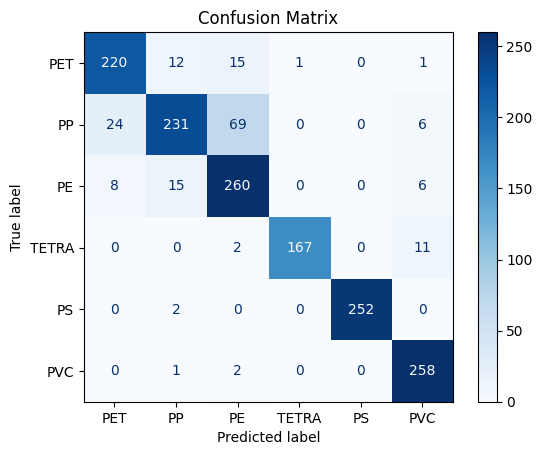

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Collect true and predicted labels
y_true = []  # True labels from the test set
y_pred = []  # Predicted labels from the model

# Get predictions from your model on the test set
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5])  
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['PET', 'PP', 'PE', 'TETRA', 'PS', 'PVC'])

# Plot and save confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_TL_without.png')  # Save the confusion matrix as a PNG file
plt.show()


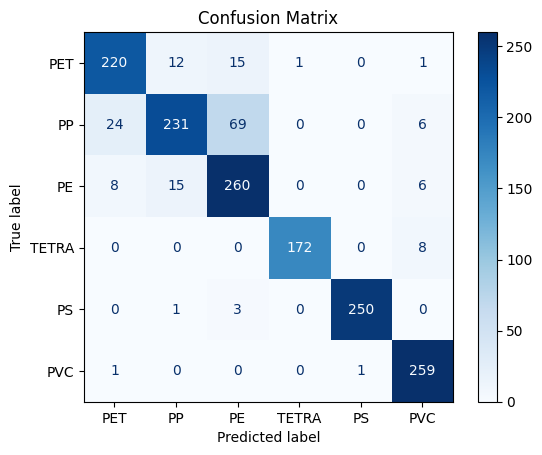

              precision    recall  f1-score   support

         PET       0.87      0.88      0.88       249
          PP       0.89      0.70      0.78       330
          PE       0.75      0.90      0.82       289
       TETRA       0.99      0.96      0.97       180
          PS       1.00      0.98      0.99       254
         PVC       0.93      0.99      0.96       261

    accuracy                           0.89      1563
   macro avg       0.90      0.90      0.90      1563
weighted avg       0.90      0.89      0.89      1563



In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import torch

# Assuming you have your true labels and predicted labels
y_true = []  # Replace with your true labels
y_pred = []  # Replace with your predicted labels

# Get predictions from your model
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute confusion matrix
labels = [0, 1, 2, 3, 4, 5]  # Update based on your classes
cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['PET', 'PP', 'PE', 'TETRA', 'PS', 'PVC'])

# Plot and save confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_TL.png')
plt.show()

# Calculate classification metrics
target_names = ['PET', 'PP', 'PE', 'TETRA', 'PS', 'PVC']
report = classification_report(y_true, y_pred, target_names=target_names)
print(report)

# Save the classification report
with open("classification_report_TL.txt", "w") as f:
    f.write(report)